In [1]:
import os 
os.chdir("..") 
print(os.getcwd())

/Users/282066/Documents/PHD/Importance Sampling/importance-sampling


In [2]:
from scipy.io import loadmat
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

from src.importance_sampling.sampling import ImportanceSampler
from src.utils.analysis_utils import prepare_embeddings, summarize_all_metrics, bootstrap_delta_metrics, summarize_all_deltas
# from src.utils.fairness_general import  tpr_fpr_fnr
from src.utils.visualisation import plot_metric_bars, plot_pca_joint_kde, plot_pca_tripanel_hexbin


/Users/282066/Documents/PHD/Importance Sampling/importance-sampling/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set paths
DATA_PATH = "data/processed/langdetect_combined.pkl"

In [4]:
# Load data
df = pd.read_pickle(DATA_PATH)
print(f"Loaded {len(df)} rows")

Loaded 191827 rows


In [5]:
# Inspect structure
df["source"].value_counts()

source
cc100      182523
tatoeba      9304
Name: count, dtype: int64

In [7]:
# (Optional) Apply PCA
# This can make later visualizations easier and reduce dimensionality

features = "sentence_vector"  # or "mean_embedding"
use_pca = True  # toggle between full embedding or PCA

df = prepare_embeddings(df, embedding_col=features, use_pca= use_pca, n_components=35)


Applying PCA to reduce from 256 to 35 dimensions...
Total variance explained by 35 components: 85.65%


In [8]:
# Define domains
df_source = df[df["source"].str.contains("cc100")]
df_target = df[df["source"].str.contains("tatoeba")]

print(f"Source: {len(df_source)} samples")
print(f"Target: {len(df_target)} samples")

Source: 182523 samples
Target: 9304 samples


In [9]:
n_components = 5
embeddings = [f'embedding_{i}' for i in range(n_components)]

n_components = 256
pca_components = [f'pc{i+1}' for i in range(n_components)]

In [10]:
# Set parameters 
N_ITERS = 100
N_SAMPLES = 5000
ignore_columns = [
    'text', 'lang', 'source', 'predicted_lang', 'probability',
       'sentence_vector', 
]

In [11]:
# Run importance sampling 
imp = ImportanceSampler(source=df_source, target=df_target, ignore_cols=ignore_columns)
imp.fit()
df_sample, _, df_weighted = imp.sample(n=N_SAMPLES, attempts=N_ITERS)
# imp.plot(df_sample, maxcols=3)

Current best logistic target prob avg at iter 1: 0.068


In [12]:
# Compute metrics 
datasets = {
    "Source": df_source,
    "Target": df_target,
    "Sample": df_sample,
    "Weighted": df_weighted,
}

results_df = summarize_all_metrics(datasets, 
                                   label_col='lang', 
                                   pred_col='predicted_lang', 
                                   average = 'weighted',
                                   n_bootstrap = 1000)
print(results_df)

        set     metric      mean     lower     upper
0    Source  precision  0.997203  0.996959  0.997446
1    Source     recall  0.987544  0.987037  0.988024
2    Target  precision  0.981124  0.978280  0.983854
3    Target     recall  0.957305  0.953138  0.961414
4    Sample  precision  0.991779  0.989295  0.994155
5    Sample     recall  0.983615  0.979800  0.987000
6  Weighted  precision  0.991664  0.990400  0.992876
7  Weighted     recall  0.984451  0.982835  0.986059


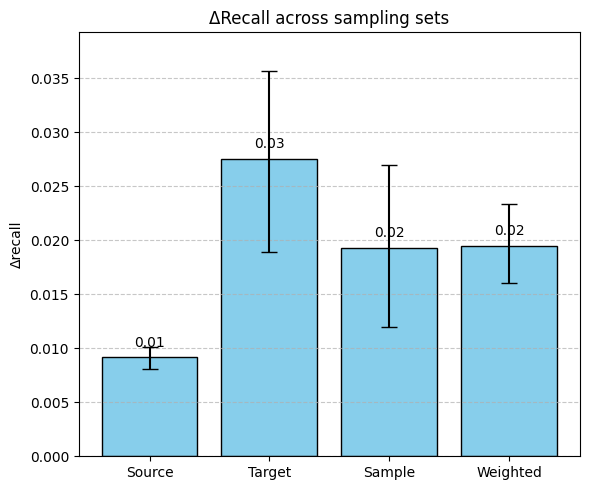

In [14]:
# Compute bootstrap metric differences vs Target
# Compute metrics 
datasets = {
    "Source": df_source,
    "Target": df_target,
    "Sample": df_sample,
    "Weighted": df_weighted,
}

results_df = summarize_all_deltas(datasets, 
                                    group_col="lang",
                                    group_a='nld',
                                    group_b='afr',
                                    label_col="lang",
                                    pred_col="predicted_lang",
                                    n_bootstrap=1000,
                                    average = 'weighted')

# Plot metrics
plot_metric_bars(results_df, metric="Δrecall", title="ΔRecall across sampling sets")